### Test finetuned YOLOv11


In [1]:
# ONLY RUN GOOGLE COLAB, Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd /content/drive/MyDrive/'Colab Notebooks/human-activity-understanding/final-project'

/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/final-project


Visualizing 3 random images...


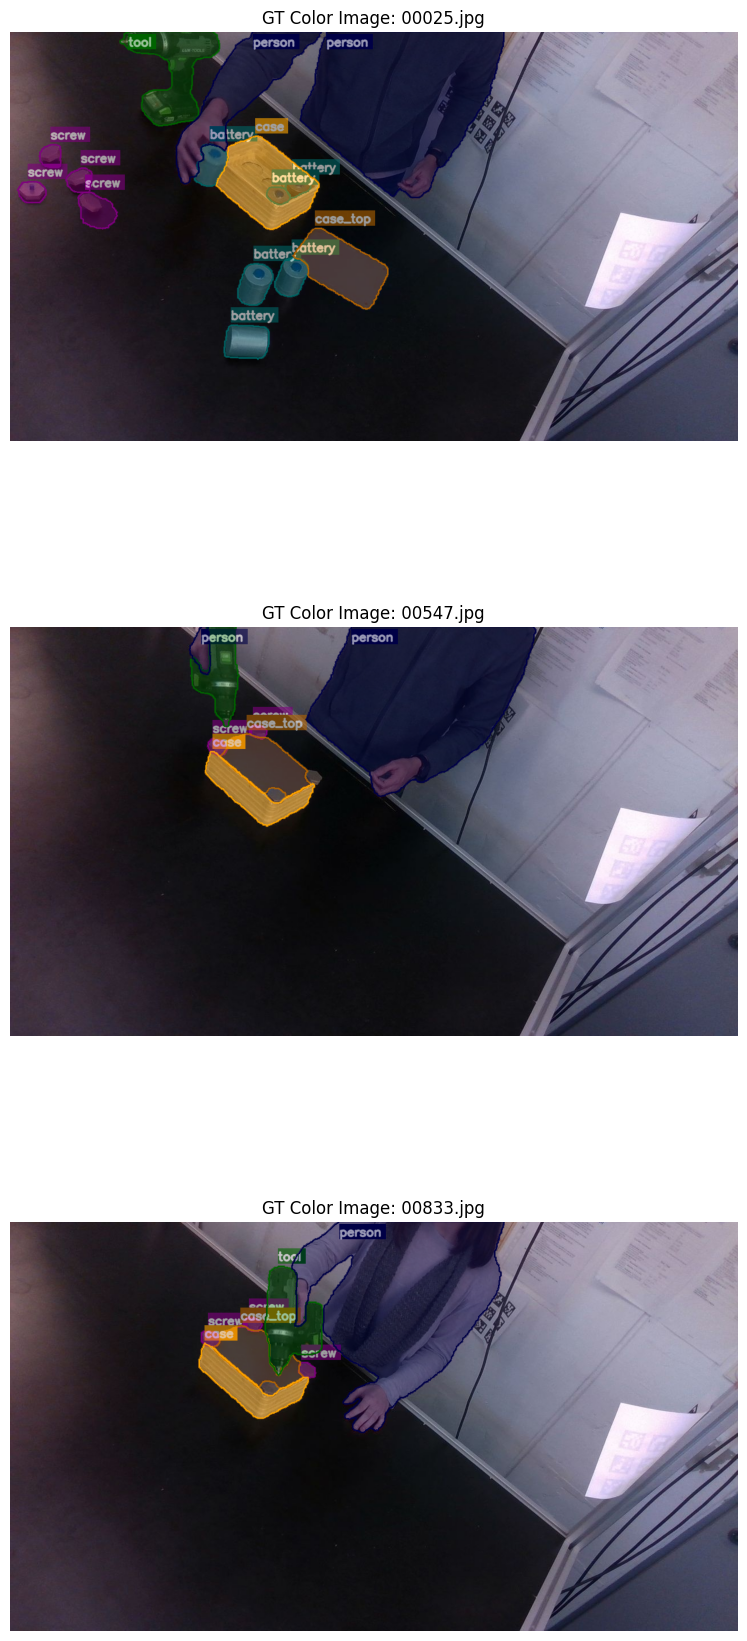

Finished visualizing 3 images with color annotations.


In [33]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np # numpy is used in draw_bboxes_and_labels

# Re-define CLASSES as it was not in the current scope
CLASSES = ["person","case","case_top", "battery","screw", "tool"]

def parse_yolo_label(label_path, img_width, img_height):
    """
    Parses a YOLO format segmentation label file and returns a list of masks.
    Each mask is returned as (class_id, polygon_points) where polygon_points is a list of (x, y) tuples in pixel coordinates.
    """
    masks = []
    if not os.path.exists(label_path):
        print(f"Warning: Label file not found: {label_path}")
        return masks

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 3: # Must have at least class_id, x1, y1
                class_id = int(parts[0])
                polygon_normalized = list(map(float, parts[1:]))

                # Convert normalized coordinates to pixel coordinates
                polygon_points = []
                for i in range(0, len(polygon_normalized), 2):
                    x = int(polygon_normalized[i] * img_width)
                    y = int(polygon_normalized[i+1] * img_height)
                    polygon_points.append((x, y))
                masks.append((class_id, polygon_points))
    return masks

def draw_bboxes_and_labels(image, masks, classes):
    """
    Draws segmentation masks and class labels on an image with semi-transparent colors.
    """
    img_copy = image.copy()
    overlay = img_copy.copy()
    alpha = 0.4  # Transparency factor

    # Define a set of distinct colors for classes (BGR format for OpenCV)
    class_colors = [
      (0, 0, 70),   # person: bluelish
      (255, 165, 0), # case: orange
      (180, 100, 0),  # case_top:
      (0, 100, 100),  # battery: Grenn
      (128, 0, 128),   # screw: violet
      (0, 100, 0)  # tool: Green
    ]

    for class_id, polygon_points in masks:
        if polygon_points:
            # Get color for the class
            color = class_colors[class_id % len(class_colors)] if class_id < len(class_colors) else (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # Fallback random color

            # Reshape points for cv2.fillPoly and cv2.polylines
            pts = np.array(polygon_points, np.int32)
            pts = pts.reshape((-1, 1, 2))

            # Fill the polygon on the overlay with semi-transparency
            cv2.fillPoly(overlay, [pts], color)

            # Draw polygon outline
            cv2.polylines(img_copy, [pts], True, color, 2)

            # Put label
            label = classes[class_id] if class_id < len(classes) else f"Unknown Class {class_id}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            font_thickness = 2
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

            # Place text near the first point of the polygon
            text_x = polygon_points[0][0]
            text_y = polygon_points[0][1] - 10 if polygon_points[0][1] - 10 > text_size[1] else polygon_points[0][1] + text_size[1] + 10

            # Draw background for text
            cv2.rectangle(img_copy, (text_x, text_y - text_size[1] - 5),
                          (text_x + text_size[0] + 5, text_y + 5), color, -1)
            cv2.putText(img_copy, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    # Combine the original image with the overlay using the transparency factor
    img_with_masks = cv2.addWeighted(overlay, alpha, img_copy, 1 - alpha, 0)
    return img_with_masks

# Define the new directories
TRAIN_IMAGES_DIR = 'dataset_yolo/images/val'
TRAIN_LABELS_DIR = 'dataset_yolo/labels/val'


# Get a list of all image files in the new training directory
train_image_files = [f for f in os.listdir(TRAIN_IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg'))]

# Randomly select 3 images to visualize
num_images_to_visualize = min(3, len(train_image_files)) # Ensure we don't try to visualize more than available
selected_images_for_viz = random.sample(train_image_files, num_images_to_visualize)

print(f"Visualizing {num_images_to_visualize} random images...")

plt.figure(figsize=(15, 6 * num_images_to_visualize))

for i, img_filename in enumerate(selected_images_for_viz):
    img_path = os.path.join(TRAIN_IMAGES_DIR, img_filename)
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(TRAIN_LABELS_DIR, label_filename)


    # Read the color image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image: {img_path}")
        continue

    # OpenCV reads images as BGR, convert to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    img_height, img_width, _ = img_rgb.shape

    # Parse YOLO labels
    bboxes = parse_yolo_label(label_path, img_width, img_height)

    # Draw bounding boxes and labels on the color image
    img_with_boxes = draw_bboxes_and_labels(img_rgb, bboxes, CLASSES)


    # Display the annotated color image
    plt.subplot(num_images_to_visualize, 2, i * 2 + 1) # First column for color image
    plt.imshow(img_with_boxes)
    plt.title(f"GT Color Image: {img_filename}")
    plt.axis('off')



plt.tight_layout()
plt.show()

print(f"Finished visualizing {num_images_to_visualize} images with color annotations.")

### Install Ultralytics

In [2]:
get_ipython().system('pip install ultralytics')
print("ultralytics package installed.")

Looking in indexes: http://jetson.webredirect.org/jp6/cu126, https://pypi.ngc.nvidia.com
ERROR: Operation cancelled by user
^C
Looking in indexes: http://jetson.webredirect.org/jp6/cu126, https://pypi.ngc.nvidia.com
ERROR: Could not find a version that satisfies the requirement ultralytics (from versions: none)
ERROR: No matching distribution found for ultralytics
ultralytics package installed for Jetson Orin Nano.


## Load Pre-trained Ultralytics Model

Load a suitable pre-trained YOLOv8 from the `ultralytics` hub as a starting point for fine-tuning.


In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 segmentation model
model = YOLO('yolo11m-seg.pt')

# Optimized Training Call
model.train(
    data='dataset_yolo/data.yaml',
    epochs=100,
    imgsz=1280,
    name='yolov11m_seg_custom',

    # --- SPEED OPTIMIZATIONS FOR A100 ---
    device=0,        # Explicitly enforce GPU usage
    batch=-1,        # KEY CHANGE: Auto-calculates the max batch size to fill VRAM
    cache=True,      # KEY CHANGE: Loads all images into RAM to remove disk I/O bottlenecks
    workers=8,       # Increases parallel data loading (Colab usually allows 4-8 workers)
    amp=True,        # Ensures Mixed Precision (Float16) is enabled (usually default)
    exist_ok=false,   # Overwrites existing project/name instead of creating new folders
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, ker

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Plot finetuning Training Results.

image_path = os.path.join('runs', 'segment', 'yolov11m_seg_custom', 'results.png')

if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(15, 8))
    plt.imshow(img)
    plt.title('YOLOv8 Segmentation Training Results')
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Image not found at {image_path}")

Error: Image not found at runs/segment/yolov11m_seg_custom/results.png


In [31]:
import cv2
import numpy as np
import random

def draw_rect_boxes_and_labels(image, boxes, classes):
    """
    Draws rectangular bounding boxes and class labels on an image.
    """
    img_copy = image.copy()

    # Define a set of distinct colors for classes (BGR format for OpenCV)
    class_colors = [
      (0, 0, 70),   # person: bluelish
      (255, 165, 0), # case: orange
      (180, 100, 0),  # case_top:
      (0, 100, 100),  # battery: Grenn
      (128, 0, 128),   # screw: violet
      (0, 100, 0)  # tool: Green
    ]

    if boxes is not None and len(boxes) > 0:
        for box_data in boxes:
            x1, y1, x2, y2 = map(int, box_data.xyxy[0])
            class_id = int(box_data.cls[0])
            confidence = float(box_data.conf[0]) # Extract confidence score

            # Get color for the class
            color = class_colors[class_id % len(class_colors)] if class_id < len(class_colors) else (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # Fallback random color

            # Draw rectangle
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 2)

            # Put label
            label = classes[class_id] if class_id < len(classes) else f"Unknown Class {class_id}"
            label_with_score = f"{label} {confidence:.2f}" # Append confidence score
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.4
            font_thickness = 1
            text_size = cv2.getTextSize(label_with_score, font, font_scale, font_thickness)[0]

            # Place text above the bounding box
            text_x = x1
            text_y = y1 - 10 if y1 - 10 > text_size[1] else y1 + text_size[1] + 10

            # Draw background for text
            cv2.rectangle(img_copy, (text_x, text_y - text_size[1] - 5),
                          (text_x + text_size[0] + 5, text_y + 5), color, -1)
            cv2.putText(img_copy, label_with_score, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    return img_copy


In [32]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the best trained model weights
model_path = os.path.join('runs', 'segment', 'yolov11m_seg_custom', 'weights', 'best.pt')
model = YOLO(model_path)

print(f"Loaded fine-tuned model from: {model_path}")

# Define the new directories and classes (same as used for training)

CLASSES = ["person","case","case_top", "battery","screw", "tool"]

# Path to the YOLO dataset validation images
val_images_dir = os.path.join('dataset_yolo', 'images', 'val')
val_labels_dir = os.path.join('dataset_yolo', 'labels', 'val')


# Get a list of all image files in the validation directory
val_image_files = [f for f in os.listdir(val_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

Loaded fine-tuned model from: runs/segment/yolov11m_seg_custom/weights/best.pt


Visualizing 1 random validation images with color and ROIs...



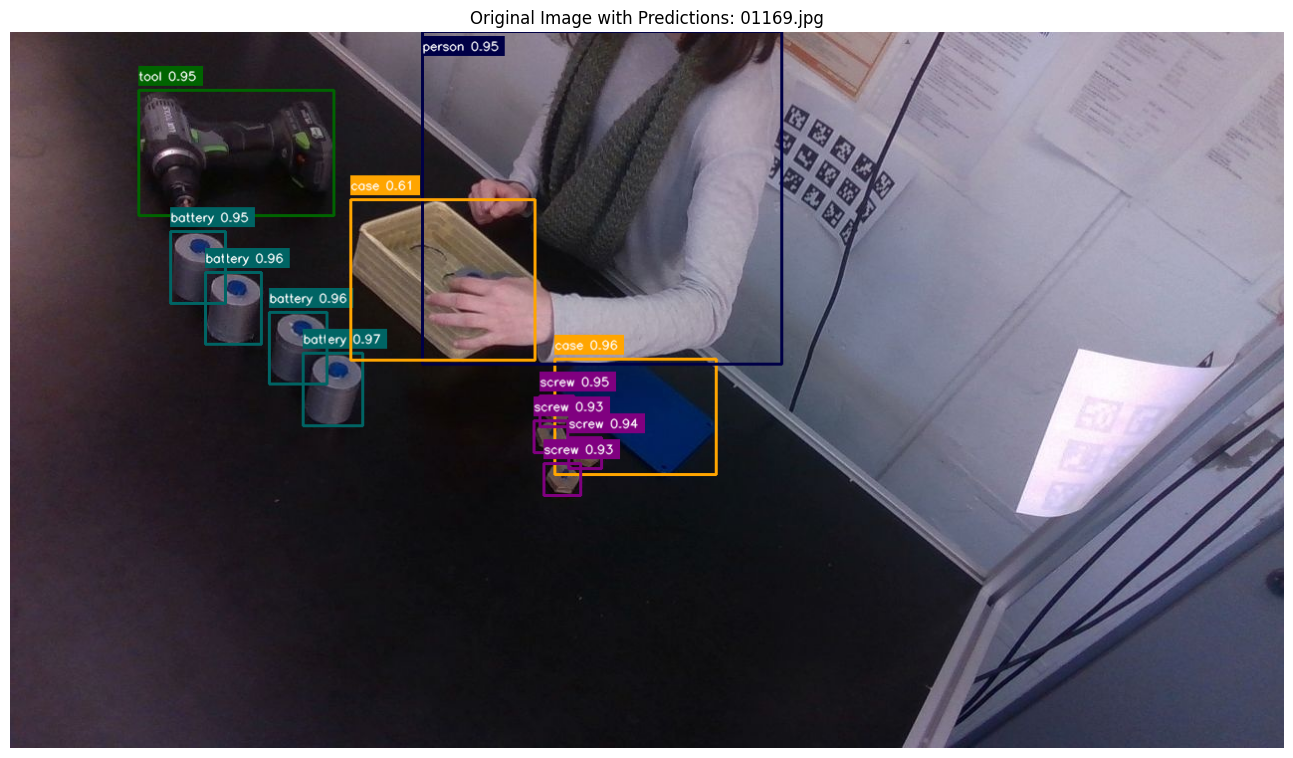

Finished visualizing 1 validation images with color and ROIs.


In [34]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np # Ensure numpy is imported if not already in scope via another cell

# Define CLASSES (ensure it's in scope)
CLASSES = ["person","case","case_top", "battery","screw", "tool"]

# Path to the YOLO dataset validation images
val_images_dir = os.path.join('dataset_yolo', 'images', 'val')
val_labels_dir = os.path.join('dataset_yolo', 'labels', 'val')


# Randomly select one images to visualize from the validation set
num_images_to_visualize = min(1, len(val_image_files)) # Ensure we don't try to visualize more than available
selected_images_for_viz = random.sample(val_image_files, num_images_to_visualize)

print(f"Visualizing {num_images_to_visualize} random validation images with color and ROIs...\n")

# Adjust figsize to accommodate 2 rows of 2 images each (assuming num_images_to_visualize=1)
plt.figure(figsize=(30, 15))

for i, img_filename in enumerate(selected_images_for_viz):
    img_path = os.path.join(val_images_dir, img_filename)
    depth_filename = os.path.splitext(img_filename)[0] + '.png'


    # Read the color image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image: {img_path}")
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    # Run inference
    results = model(img_rgb, verbose=False)

    # --- Logic to find the object for ROI display ---
    selected_bbox_for_roi = None
    selected_class_id_for_roi = None
    all_detected_boxes = [] # Collect all boxes for the first subplot
    found_table_for_roi = False

    for r in results:
        if r.boxes and len(r.boxes) > 0:
            # Collect all boxes for displaying all detections
            all_detected_boxes.extend(r.boxes)


    # --- First Row: All Detections---
    # Display the annotated color image (all detections)
    img_with_all_predictions = img_rgb.copy()
    img_with_all_predictions = draw_rect_boxes_and_labels(img_rgb.copy(), all_detected_boxes, CLASSES)
    plt.subplot(2, 2, 1) # First row, first column
    plt.imshow(img_with_all_predictions)
    plt.title(f"Original Image with Predictions: {img_filename}")
    plt.axis('off')



plt.tight_layout()
plt.show()

print(f"Finished visualizing {num_images_to_visualize} validation images with color and ROIs.")


Visualizing 1 random validation images...


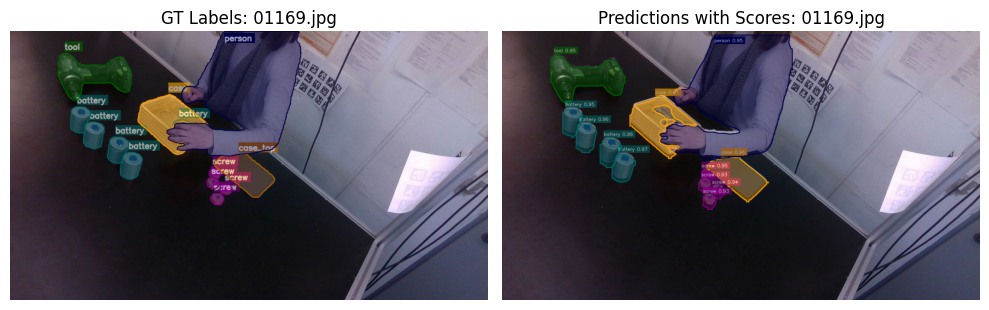

In [39]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np # Added numpy import

# Define a new helper function to draw masks with scores
def draw_masks_and_scores(image, masks_with_scores, classes):
    """
    Draws segmentation masks, class labels, and confidence scores on an image with semi-transparent colors.
    """
    img_copy = image.copy()
    overlay = img_copy.copy()
    alpha = 0.4  # Transparency factor

   # Define a set of distinct colors for classes (BGR format for OpenCV)
    class_colors = [
      (0, 0, 70),   # person: bluelish
      (255, 165, 0), # case: orange
      (180, 100, 0),  # case_top:
      (0, 100, 100),  # battery: Grenn
      (128, 0, 128),   # screw: violet
      (0, 100, 0)  # tool: Green
    ]

    for class_id, polygon_points, score in masks_with_scores:
        if polygon_points:
            # Get color for the class
            color = class_colors[class_id % len(class_colors)] if class_id < len(class_colors) else (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # Fallback random color

            # Reshape points for cv2.fillPoly and cv2.polylines
            pts = np.array(polygon_points, np.int32)
            pts = pts.reshape((-1, 1, 2))

            # Fill the polygon on the overlay with semi-transparency
            cv2.fillPoly(overlay, [pts], color)

            # Draw polygon outline
            cv2.polylines(img_copy, [pts], True, color, 2)

            # Put label with score
            label_text = classes[class_id] if class_id < len(classes) else f"Unknown Class {class_id}"
            label_text = f"{label_text} {score:.2f}" # Add score here

            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.4
            font_thickness = 1
            text_size = cv2.getTextSize(label_text, font, font_scale, font_thickness)[0]

            # Place text near the first point of the polygon
            text_x = polygon_points[0][0]
            text_y = polygon_points[0][1] - 10 if polygon_points[0][1] - 10 > text_size[1] else polygon_points[0][1] + text_size[1] + 10

            # Draw background for text
            cv2.rectangle(img_copy, (text_x, text_y - text_size[1] - 5),
                          (text_x + text_size[0] + 5, text_y + 5), color, -1)
            cv2.putText(img_copy, label_text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    # Combine the original image with the overlay using the transparency factor
    img_with_masks = cv2.addWeighted(overlay, alpha, img_copy, 1 - alpha, 0)
    return img_with_masks


print(f"Visualizing {num_images_to_visualize} random validation images...")

plt.figure(figsize=(10, 5))

for i, img_filename in enumerate(selected_images_for_viz):
    img_path = os.path.join(val_images_dir, img_filename)
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(val_labels_dir, label_filename)

    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image: {img_path}")
        continue

    # OpenCV reads images as BGR, convert to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get image dimensions for parsing labels
    img_height, img_width, _ = img_rgb.shape

    # --- Ground Truth Labels ---
    gt_masks = parse_yolo_label(label_path, img_width, img_height)
    img_with_gt = draw_bboxes_and_labels(img_rgb.copy(), gt_masks, CLASSES)

    # --- Model Predictions ---
    # Run inference
    results = model(img_rgb, verbose=False) # verbose=False to suppress output for each image

    # Process results to get masks in the desired format
    predicted_masks_with_scores = []
    for r in results:
        if r.masks is not None:
            for j, mask_data in enumerate(r.masks.data):
                class_id = int(r.boxes.cls[j])
                confidence_score = float(r.boxes.conf[j]) # Get confidence score
                # Convert mask to polygon points
                mask_np = mask_data.cpu().numpy().astype(np.uint8)
                contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    # Take the largest contour for simplicity if multiple are found
                    contour = max(contours, key=cv2.contourArea)
                    # Reshape to (N, 2) list of tuples for draw_masks_and_scores
                    polygon_points = [tuple(point[0]) for point in contour]
                    predicted_masks_with_scores.append((class_id, polygon_points, confidence_score)) # Append score

    # Draw bounding boxes and labels using the newly defined helper function
    img_with_predictions = draw_masks_and_scores(img_rgb.copy(), predicted_masks_with_scores, CLASSES)

    # --- Display Both ---
    plt.subplot(num_images_to_visualize, 2, i * 2 + 1) # First column for GT
    plt.imshow(img_with_gt)
    plt.title(f"GT Labels: {img_filename}")
    plt.axis('off')

    plt.subplot(num_images_to_visualize, 2, i * 2 + 2) # Second column for Predictions
    plt.imshow(img_with_predictions)
    plt.title(f"Predictions with Scores: {img_filename}")
    plt.axis('off')

plt.tight_layout()
plt.show()

